# Marketing Channel Attribution with Markov Chains 

#### Information about the Markov Chains and Attribution on [Here](https://medium.com/@mortenhegewald/marketing-channel-attribution-using-markov-chains-101-in-python-78fb181ebf1e)

Markov chains, in the context of channel attribution, gives us a framework to statistically model user journeys and how each channel factors into the users traveling from one channel to another to eventually convert (or not). By using these transition probabilities, we can identify the statistical impact a single channel has on our total conversions.

The dataset for this notebook can be downloaded [here](https://www.dropbox.com/sh/m5d8u7inolw32xu/AADuHNcGToa7ajTcF_JjEkcca?dl=0)

Breif Explanation of dataset.

For every unique customer and visit our data set this time around contains the following information in every row:

- Cookie: Randomly generated customer id enabling us to tie subsequent visits back to the same customer
- Timestamp: Date and time when the visit took place
- Interaction: Categorical variable indicating the type of interaction that took place
- Conversion: Boolean variable indicating whether a conversion took place
- Conversion Value: Value of the potential conversion event
- Channel: The marketing channel that brought the customer to our site

The data set contains ~586,000 marketing touch-points for ~240,000 unique customers which resulted in ~18,000 thousand conversion events. In tabular format the data set will look like this:

## 1.0 Import Libraries and Load Data

In [1]:
import gc
import os
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
from collections import defaultdict

In [2]:
df = pd.read_csv('./data/attribution.csv')

df = df.sort_values(['cookie', 'time'],
                    ascending=[False, True])

# New column indicating the order of the touch-points for each user
df['visit_order'] = df.groupby('cookie').cumcount() + 1

In [3]:
df.head()

,cookie,time,interaction,conversion,conversion_value,channel,visit_order
586736,ooooohAFofEnonEikhAi3fF9o,2018-07-14T17:17:12Z,impression,0,0.0,Paid Search,1
586734,ooooiBh70D3k3BfAhDFfii9h7,2018-07-03T12:57:25Z,impression,0,0.0,Paid Search,1
586735,ooooiBh70D3k3BfAhDFfii9h7,2018-07-19T08:17:59Z,impression,0,0.0,Online Video,2
586731,ooooEiB0CCoEf9fiiC90Dfhfk,2018-07-06T23:30:38Z,impression,0,0.0,Online Display,1
586732,ooooEiB0CCoEf9fiiC90Dfhfk,2018-07-12T23:50:45Z,impression,0,0.0,Online Display,2


#### Pivoting the data frame from long-form to wide-form, so we ultimately get a single row per user

In [167]:
# grouping the chronological touch-points into a list
df_paths = df.groupby('cookie')['channel'].aggregate(
    lambda x: x.unique().tolist()).reset_index()
    
# merging the list of final conversion/non-conversion events onto that data    
df_last_interaction = df.drop_duplicates('cookie', keep='last')[['cookie', 'conversion']]

df_paths = pd.merge(df_paths, df_last_interaction, how='left', on='cookie')

# adding a “Null” or “Conversion” event to the end of our user-journey lists
df_paths['path'] = np.where(df_paths['conversion'] == 0,
                            ['Start, '] + df_paths['channel'].apply(', '.join) + [', Null'],
                            ['Start, '] + df_paths['channel'].apply(', '.join) + [', Conversion'])

df_paths['path'] = df_paths['path'].str.split(', ')

df_paths = df_paths[['cookie', 'path']]

In [168]:
df_paths.head()

,cookie,path
0,00000FkCnDfDDf0iC97iC703B,"[Start, Instagram, Online Display, Null]"
1,0000nACkD9nFkBBDECD3ki00E,"[Start, Paid Search, Null]"
2,0003EfE37E93D0BC03iBhBBhF,"[Start, Paid Search, Null]"
3,00073CFE3FoFCn70fBhB3kfon,"[Start, Instagram, Null]"
4,00079hhBkDF3k3kDkiFi9EFAD,"[Start, Paid Search, Null]"


## 2.0 Markov Chains

We can now move onto the actual Markov Chain method.
The algorithm for Markov Chains can be summarized in 2 steps:
- Calculate transition probabilities between all states in our state-space
- Calculate removal effects (for more info on removal effects, see part 1)

#### We’ll start by defining a list of all user journeys, the number of total conversion and the base level conversion rate.

In [169]:
list_of_paths = df_paths['path']
total_conversions = sum(path.count('Conversion') for path in df_paths['path'].tolist())
base_conversion_rate = total_conversions / len(list_of_paths)

In [170]:
total_conversions

17639

In [171]:
base_conversion_rate

0.07346277508454528

#### Next, we’ll define a function that identifies all potential state transitions and outputs a dictionary containing these. We’ll use this as an input when calculating transition probabilities:

In [172]:
def transition_states(list_of_paths):
    list_of_unique_channels = set(x for element in list_of_paths for x in element)
    transition_states = {x + '>' + y: 0 for x in list_of_unique_channels for y in list_of_unique_channels}

    for possible_state in list_of_unique_channels:
        if possible_state not in ['Conversion', 'Null']:
            for user_path in list_of_paths:
                if possible_state in user_path:
                    indices = [i for i, s in enumerate(user_path) if possible_state in s]
                    for col in indices:
                        transition_states[user_path[col] + '>' + user_path[col + 1]] += 1

    return transition_states


trans_states = transition_states(list_of_paths)

#### And the function to calculate all transition probabilities can be defined as:

In [173]:
def transition_prob(trans_dict):
    list_of_unique_channels = set(x for element in list_of_paths for x in element)
    trans_prob = defaultdict(dict)
    for state in list_of_unique_channels:
        if state not in ['Conversion', 'Null']:
            counter = 0
            index = [i for i, s in enumerate(trans_dict) if state + '>' in s]
            for col in index:
                if trans_dict[list(trans_dict)[col]] > 0:
                    counter += trans_dict[list(trans_dict)[col]]
            for col in index:
                if trans_dict[list(trans_dict)[col]] > 0:
                    state_prob = float((trans_dict[list(trans_dict)[col]])) / float(counter)
                    trans_prob[list(trans_dict)[col]] = state_prob

    return trans_prob


trans_prob = transition_prob(trans_states)

In [174]:
trans_prob

defaultdict(dict,
            {'Online Video>Conversion': 0.0781455983594551,
             'Online Video>Null': 0.7637566525072018,
             'Online Video>Instagram': 0.03190762169815927,
             'Online Video>Paid Search': 0.04794687759386749,
             'Online Video>Facebook': 0.059323275230701626,
             'Online Video>Online Display': 0.018919974610614718,
             'Start>Online Video': 0.14236093757808985,
             'Start>Instagram': 0.11918803205224315,
             'Start>Paid Search': 0.31739883718993117,
             'Start>Facebook': 0.2784080497109634,
             'Start>Online Display': 0.14264414346877238,
             'Instagram>Conversion': 0.057979218048760765,
             'Instagram>Online Video': 0.024117575708567502,
             'Instagram>Null': 0.6297861157158452,
             'Instagram>Paid Search': 0.04580924271216593,
             'Instagram>Facebook': 0.2187765333764606,
             'Instagram>Online Display': 0.023531314438199977,

#### Now, "trans_prob" is a dictionary containing all transitions and their respective transition probabilities given our historical data.

#### The final step is then to identify removal effects for each of our marketing channels. To do this we’ll make use of linear algebra and matrix manipulations, therefore let’s turn our above transition probabilities dictionary into a data frame (matrix):

In [175]:
def transition_matrix(list_of_paths, transition_probabilities):
    trans_matrix = pd.DataFrame()
    list_of_unique_channels = set(x for element in list_of_paths for x in element)

    for channel in list_of_unique_channels:
        trans_matrix[channel] = 0.00
        trans_matrix.loc[channel] = 0.00
        trans_matrix.loc[channel][channel] = 1.0 if channel in ['Conversion', 'Null'] else 0.0

    for key, value in transition_probabilities.items():
        origin, destination = key.split('>')
        trans_matrix.at[origin, destination] = value

    return trans_matrix


trans_matrix = transition_matrix(list_of_paths, trans_prob)

In [176]:
trans_matrix

,Conversion,Online Video,Null,Start,Instagram,Paid Search,Facebook,Online Display
Conversion,1.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000
Online Video,0.078146,0.000000,0.763757,0.0,0.031908,0.047947,0.059323,0.018920
Null,0.000000,0.000000,1.000000,0.0,0.000000,0.000000,0.000000,0.000000
Start,0.000000,0.142361,0.000000,0.0,0.119188,0.317399,0.278408,0.142644
Instagram,0.057979,0.024118,0.629786,0.0,0.000000,0.045809,0.218777,0.023531
Paid Search,0.053309,0.029221,0.770779,0.0,0.034196,0.000000,0.064442,0.048053
Facebook,0.053220,0.025577,0.673123,0.0,0.173072,0.050655,0.000000,0.024352
Online Display,0.050324,0.017299,0.756643,0.0,0.029363,0.092386,0.053986,0.000000


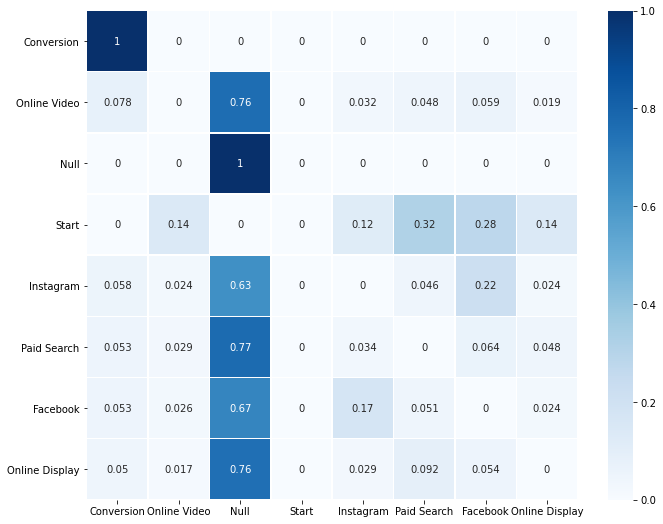

In [182]:
fig, ax = plt.subplots(figsize=(11, 9))
# plot heatmap
sns.heatmap(trans_matrix, cmap="Blues",annot=True, linewidths=.5)
plt.show()

## 3.0 Interpretation 

#### The transition matrix we just produced actually holds a great deal of valuable information on its own. An immediate derivative of it would be to generate a directional graph or transition heat map to visualize the typical user journeys.

#### We gain critical information around how our marketing channels are interacting with each other. Given today’s typical multi-touch conversion journeys this information can prove to be extremely valuable and allows us to optimize our multi-channel customer journeys for conversion

### We can now iteratively go through each of our channels and assess the impact it would have on overall conversion if we were to remove a channel from our state-space. We’ll do this and add the resulting removal effects to an output dictionary:

In [183]:
def removal_effects(df, conversion_rate):
    removal_effects_dict = {}
    channels = [channel for channel in df.columns if channel not in ['Start',
                                                                     'Null',
                                                                     'Conversion']]
    for channel in channels:
        removal_df = df.drop(channel, axis=1).drop(channel, axis=0)
        for column in removal_df.columns:
            row_sum = np.sum(list(removal_df.loc[column]))
            null_pct = float(1) - row_sum
            if null_pct != 0:
                removal_df.loc[column]['Null'] = null_pct
            removal_df.loc['Null']['Null'] = 1.0

        removal_to_conv = removal_df[
            ['Null', 'Conversion']].drop(['Null', 'Conversion'], axis=0)
        removal_to_non_conv = removal_df.drop(
            ['Null', 'Conversion'], axis=1).drop(['Null', 'Conversion'], axis=0)

        removal_inv_diff = np.linalg.inv(
            np.identity(
                len(removal_to_non_conv.columns)) - np.asarray(removal_to_non_conv))
        removal_dot_prod = np.dot(removal_inv_diff, np.asarray(removal_to_conv))
        removal_cvr = pd.DataFrame(removal_dot_prod,
                                   index=removal_to_conv.index)[[1]].loc['Start'].values[0]
        removal_effect = 1 - removal_cvr / conversion_rate
        removal_effects_dict[channel] = removal_effect

    return removal_effects_dict


removal_effects_dict = removal_effects(trans_matrix, base_conversion_rate)

#### Then, let's calculate the Markov Chain attributions for each of our marketing channels:

In [184]:
def markov_chain_allocations(removal_effects, total_conversions):
    re_sum = np.sum(list(removal_effects.values()))

    return {k: (v / re_sum) * total_conversions for k, v in removal_effects.items()}


attributions = markov_chain_allocations(removal_effects_dict, total_conversions)

In [185]:
attributions

{'Online Video': 2886.4480895461475,
 'Instagram': 3031.521548555893,
 'Paid Search': 4618.891257291356,
 'Facebook': 4948.892177847523,
 'Online Display': 2153.2469267590823}

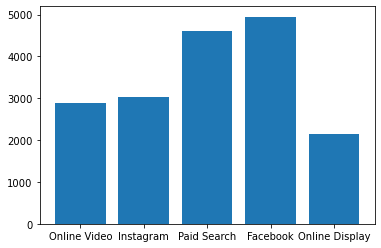

In [187]:
plt.bar(*zip(*attributions.items()))
plt.show()

### To get a better feel for the output of our labor, let’s visualize the final attributed conversion values for each channel.

### It’s important to keep in mind that while the data set in this example holds a sizeable volume of data it only includes 5 marketing channels. 

### In a real-world scenario we’d likely be working with several times that number of channels (significantly more if we applying a more granular model such as a campaign specific attribution model), consequently increasing the complexity of the typical user journey and the need for an attribution model that favours this level of complexity.

### Assigning accurate credit to marketing channels can be a complex but rewarding task. Using the Markov Chain approach outlined in this article will allow your attributions to more accurately reflect how your users are interacting with your marketing.

Reference:
https://towardsdatascience.com/marketing-channel-attribution-with-markov-chains-in-python-part-2-the-complete-walkthrough-733c65b23323